Dataset: train
  Class 0: 369 items
  Class 1: 364 items
  Class 2: 0 items
Dataset: valid
  Class 0: 39 items
  Class 1: 44 items
  Class 2: 0 items


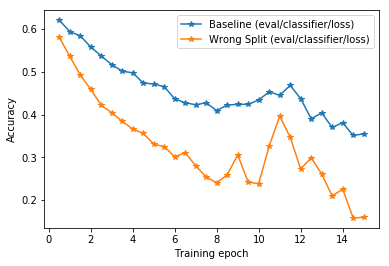

In [1]:
import json
import os
import random
import numpy as np
from sklearn import tree
from sklearn import svm
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

CLASS_NAMES = ['HC', 'AD', 'MCI']
CLASS_COUNT = len(CLASS_NAMES)
CLASS_HC = CLASS_NAMES.index('HC')
CLASS_AD = CLASS_NAMES.index('AD')
CLASS_MCI = CLASS_NAMES.index('MCI')

# Batch size 48, bn, py_streaming, no 512fc
BASELINE_RUNS = {
    'cnn': ['20180409-195126', '20180411-005423', '20180410-151641', '20180407-101054', '20180407-101051'],
    'svm': ['20180411-181756', '20180411-163159'],
    'inception': ['20180411-193238'],
}
random.seed(0)
VALID_RATIO = 0.2

def load_tensors_dump(run):
    run_file = '/local/dhaziza/data/%s/tensors_dump.json' % run
    dump_tensors = json.load(open(run_file, 'r'))
    return {
        int(k): v
        for k, v in dump_tensors.items()
    }

def load_datasets(run='20180411-120122', global_step_idx=-1, dump_tensors=None):
    if dump_tensors is None:
        dump_tensors = load_tensors_dump(run)
    global_steps = sorted(dump_tensors.keys())
    step = global_steps[global_step_idx]
    #print('Analysis on step %d' % step)
    data_per_class_train = {0: [], 1: [], 2: []}
    data_per_class_valid = {0: [], 1: [], 2: []}
    data_per_class_all = {0: [], 1: [], 2: []}
    p_id_to_dataset = {}
    for output in dump_tensors[step]:
        for label, proba, p_id in zip(output['classifier/labels'], output['classifier/logits'], output['classifier/study_patient_id']):
            #proba[1] = -proba[0]
            label_idx = np.argmax(label)
            p_id = p_id[0]
            if p_id not in p_id_to_dataset:
                if random.random() < VALID_RATIO:
                    p_id_to_dataset[p_id] = 'valid'
                else:
                    p_id_to_dataset[p_id] = 'train'
            if p_id_to_dataset[p_id] == 'valid':
                data_per_class_valid[label_idx].append(proba)
            else:
                data_per_class_train[label_idx].append(proba)
            data_per_class_all[label_idx].append(proba)
    for k in range(CLASS_COUNT):
        data_per_class_valid[k] = np.array(data_per_class_valid[k])
        data_per_class_train[k] = np.array(data_per_class_train[k])
        data_per_class_all[k] = np.array(data_per_class_all[k])
    return data_per_class_train, data_per_class_valid, data_per_class_all

def load_smt_outcome(run):
    run_file = '/local/dhaziza/data/%s/sumatra_outcome.json' % run
    return json.load(open(run_file, 'r'))

def load_smt_run(run):
    outcome = load_smt_outcome(run)
    return outcome['text_outcome'], outcome['run_reason']
    
def print_class_samples(dataset, name):
    print('Dataset: %s' % name)
    for k, v in dataset.items():
        print('  Class %d: %d items' % (k, len(v)))

def plot_smt_metric(reason_to_runs, metrics, xlabel=None, ylabel='Accuracy'):
    if not isinstance(metrics, list):
        metrics = [metrics]
    reasons, reason_runs = zip(*sorted(zip(reason_to_runs.keys(), reason_to_runs.values())))
    for reason, runs in zip(reasons, reason_runs):
        if not isinstance(runs, list):
            runs = [runs]
        x = []
        y = []
        for run in runs:
            smt_outcome = load_smt_outcome(run)['numeric_outcome']
            for m in metrics:
                x.append(smt_outcome[m]['x'])
                y.append(smt_outcome[m]['y'])
                if xlabel is None:
                    xlabel = smt_outcome[m]['x_label']
        plt.plot(x[0], np.mean(y, axis=0), label='%s (%s)' % (reason, m), marker="*")
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()
    plt.show()

data_per_class_train, data_per_class_valid, data_per_class_all = load_datasets()
print_class_samples(data_per_class_train, 'train')
print_class_samples(data_per_class_valid, 'valid')
plot_smt_metric({
    'Baseline': BASELINE_RUNS['cnn'],
    'Wrong Split': '20180411-111955',
}, 'eval/classifier/loss')

In [2]:
def decision_argmax(probas):
    return np.argmax(probas)

def decision_heur(probas):
    if probas[CLASS_AD] > 0.95:
        return CLASS_AD
    return np.argmax(probas * [1., 0, 1.])

def check_accuracy(dataset, decision_fn):
    accuracies = []
    for _class, v in dataset.items():
        accurate_count = 0
        total_count = len(v)
        for sample_output in v:
            if decision_fn(sample_output) == _class:
                accurate_count += 1
        acc = 100.0 * accurate_count / total_count if total_count > 0 else 0
        if total_count == 0:
            print('  Class %d: <no sample>' % _class)
        else:
            print('  Class %d: accuracy %.2f%% (%d/%d correct)' % (_class, acc, accurate_count, total_count))
        accuracies.append(acc)
    print('Mean Per Class Accuracy: %.2f%%' % np.mean(accuracies))

check_accuracy(data_per_class_all, decision_argmax)

  Class 0: accuracy 70.83% (289/408 correct)
  Class 1: accuracy 71.57% (292/408 correct)
  Class 2: <no sample>
Mean Per Class Accuracy: 47.47%


In [3]:
def plot_histograms():
    probas_range = 0.5
    def plot_distrib(vector, title, range=(0., probas_range)):
        plt.hist(vector, range=range)
        plt.title(title)
        plt.show()

    for k in range(CLASS_COUNT):
        plt.hist([
            data_per_class_all[k1][:, k]
            for k1 in range(CLASS_COUNT)
        ], range=(0., probas_range), density=True)
        plt.title('P(%s|input_class)' % CLASS_NAMES[k])
        plt.legend(['input_class=%s' % k1 for k1 in CLASS_NAMES])
        plt.ylabel('Probability density')
        plt.show()

    plt.hist([
        data_per_class_all[k1][:, CLASS_HC] - data_per_class_all[k1][:, CLASS_AD]
        for k1 in range(CLASS_COUNT)
    ], range=(-probas_range, probas_range), density=True)
    plt.title('P(HC - AD|input_class)')
    plt.legend(['input_class=%s' % k1 for k1 in CLASS_NAMES])
    plt.ylabel('Probability density')
    plt.show()

    plt.hist([
        data_per_class_all[k1][:, k1]
        for k1 in range(CLASS_COUNT)
    ], range=(-probas_range, probas_range), density=True)
    plt.title('P(input_class|input_class)')
    plt.legend(['input_class=%s' % k1 for k1 in CLASS_NAMES])
    plt.ylabel('Probability density')
    plt.show()



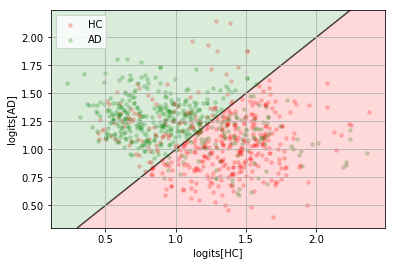

In [4]:
# Training for parameters
x = [[], [], []]
colors = ['red', 'green', 'blue']
labels = []
for k, v in data_per_class_train.items():
    if len(v) > 0:
        c = len(v[:, 0])
        x[0] += list(v[:, 0])
        x[1] += list(v[:, 1])
        if v.shape[1] > 2:
            x[2] += list(v[:, 2])
        labels += [CLASS_NAMES[k]] * c

def scatter_plot(axis0, axis1, dataset=None):
    if dataset is None:
        dataset = data_per_class_all
    fig, ax = plt.subplots()
    for i in range(len(colors)):
        if len(dataset[i]) > 0:
            p0 = dataset[i][:, axis0]
            p1 = dataset[i][:, axis1]
            ax.scatter(p0,p1,c=colors[i], label=CLASS_NAMES[i], alpha=0.2, s=12)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    # now plot both limits against eachother
    prev_lims = [ax.get_xlim(), ax.get_ylim()]
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.add_patch(
        patches.Rectangle(
                (-50., -50.),   # (x,y)
                600,          # width
                600,          # height
                facecolor=colors[axis0],
                angle=-45.0,
                alpha=0.15,
        )
    )
    ax.add_patch(
        patches.Rectangle(
                (-50., -50.),   # (x,y)
                600,          # width
                600,          # height
                facecolor=colors[axis1],
                angle=45.0,
                alpha=0.15,
        )
    )
    #ax.plot(lims, np.array(lims) + 0.01, 'k-', linewidth=5, alpha=0.5, c=colors[axis0], zorder=0)
    #ax.plot(lims, np.array(lims) - 0.01, 'k-', linewidth=5, alpha=0.5, c=colors[axis1], zorder=0)
    #ax.set_aspect('equal')
    ax.set_xlim(prev_lims[0])
    ax.set_ylim(prev_lims[1])

    ax.set_xlabel('logits[%s]' % CLASS_NAMES[axis0])
    ax.set_ylabel('logits[%s]' % CLASS_NAMES[axis1])
    ax.legend()
    ax.grid(True)
    plt.show()

scatter_plot(0, 1)
#scatter_plot(0, 2)
#scatter_plot(1, 2)

In [5]:
# Train scikit-learn trees
def dataset_to_scikit(dataset):
    X = []
    Y = []
    w = []
    for k, v in dataset.items():
        if len(v) > 0 and k != CLASS_MCI:
            count = v.shape[0]
            X += v.tolist()
            Y += ([k] * count)
            w += ([1.0/count] * count)
    return X, Y, w

def check_classifier_performance(classifier, run):
    valid_scores = []
    dump_tensors = load_tensors_dump(run)
    for step in range(-7, -1):
        this_step_scores = []
        for i in range(100):
            dataset_train, dataset_valid, _ = load_datasets(run, step, dump_tensors=dump_tensors)
            scikit_train_x, scikit_train_y, train_w = dataset_to_scikit(dataset_train)
            scikit_valid_x, scikit_valid_y, valid_w = dataset_to_scikit(dataset_valid)
            classifier = classifier.fit(scikit_train_x, scikit_train_y, train_w)
            this_step_scores.append(classifier.score(scikit_valid_x, scikit_valid_y, valid_w))
        valid_scores.append(np.mean(this_step_scores))
    print("  Valid score: %.3f [%.2f - %.2f]" % (
        np.mean(valid_scores),
        np.percentile(valid_scores, 5),
        np.percentile(valid_scores, 95),
    ))

    def predict_classifier_decision(x):
        return classifier.predict([x])
    #check_accuracy(dataset_valid, predict_classifier_decision)
    return valid_scores

"""
bl:/local/dhaziza/data/20180407-234040-debug,
    renorm:/local/dhaziza/data/20180408-084628-debug,
        nobn:/local/dhaziza/data/20180408-085750-debug,
            bn_only_input:/local/dhaziza/data/20180408-094024-debug,
                bn99_only_input:/local/dhaziza/data/20180408-100306-debug,
                    stride_first:/local/dhaziza/data/20180408-104059-debug,
                        master:/local/dhaziza/data/20180408-105319-debug
"""
# 


def do_bars_comparison_plot(runs_reasons, series, x_label='', title='untitled', ylim=[0.7, 0.9],
                           baseline_colors=None,
                           colors=None,
):
    type_to_color = {
        # Run, Baseline
        '3DCNN': ['xkcd:light blue', 'xkcd:bright blue'],
        '3DCNN_BN': ['xkcd:light blue', 'xkcd:bright blue'],
        '3DCNN_NOBN': ['xkcd:sand', 'xkcd:mustard'],
        'Inceptionv3': ['xkcd:sand', 'xkcd:mustard'],
        'SVM': ['xkcd:light green', 'xkcd:bright green'],
    }
    type_to_color = {
        # Run, Baseline
        '3DCNN': ['xkcd:green', 'xkcd:blue'],
        '3DCNN_BN': ['xkcd:green', 'xkcd:blue'],
        '3DCNN_NOBN': ['xkcd:forest green', 'xkcd:royal blue'],
        'Inceptionv3': ['xkcd:olive drab', 'xkcd:grape'],
        'SVM': ['xkcd:orange', 'xkcd:red'],
    }
    if baseline_colors is None:
        baseline_colors = [type_to_color[t][1] for t in series]
    if colors is None:
        colors = [type_to_color[t][0] for t in series]
    reasons, runs = zip(*sorted(zip(runs_reasons.keys(), runs_reasons.values())))
    series = [{
            'values': [],
            'mins': [],
            'maxs': [],
            'name': sname,
            'baseline_color': bc,
            'color': c,
        }
        for sname, bc, c in zip(series, baseline_colors, colors)
    ]
    for reason_runs in runs:
        for serie_id, serie in enumerate(series):
            try:
                repeat_runs = reason_runs[serie_id]
                if not isinstance(repeat_runs, list):
                    repeat_runs = [repeat_runs]
                v = []
                for r in repeat_runs:
                    try:
                        outcome, reason = load_smt_run(r)
                        print('Run %s (%s)' % (r, reason))
                        print('  ## %s' % outcome)
                        assert(outcome != 'TODO')
                        v += [float(outcome.split(' ')[3])]
                        #v += [np.mean(check_classifier_performance(tree.DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2), r))]
                    except:
                        pass
                assert(len(v) > 0)
                serie['values'].append(np.median(v))
                #serie['values'].append(float(outcome.split(' ')[3]))
                serie['mins'].append(np.percentile(v, 5))
                serie['maxs'].append(np.percentile(v, 95))
            except:
                serie['values'].append(0)
                serie['mins'].append(0)
                serie['maxs'].append(0)
                

    barWidth = 0.2
    r0 = np.arange(len(runs))

    # Create blue bars
    for serie_id, serie in enumerate(series):
        r_pos = [x + serie_id * barWidth for x in r0]
        yerr = [
            np.array(serie['values']) - np.array(serie['mins']),
            np.array(serie['maxs']) - np.array(serie['values']),
        ]
        color = [
            serie['baseline_color'] if 'baseline' in reasons[i] else serie['color']
            for i in range(len(reasons))
        ]
        plt.bar(r_pos, serie['values'], width = barWidth, yerr=yerr, capsize=7, label=serie['name'], color=color)

    # general layout
    plt.xticks([
        r + (0.5 * len(series) - 0.5) * barWidth
        for r in r0
    ], [r.split('__')[-1] for r in reasons])
    plt.ylim(ylim[0], ylim[1])
    plt.ylabel('AD/HC validation accuracy')
    plt.xlabel(x_label)
    plt.title(title)
    plt.legend()

    # Show graphic
    plt.show()

Run 20180410-124714 (3DCNN: keep_patients=200 / maximize_diversity && dataset size 1000)
  ## Per class accuracy 0.7421219 (std=0.006 on the last 7 steps)
Run 20180410-151305 (SVM: keep_patients=200 / maximize_diversity && dataset size 1000)
  ## Per class accuracy 0.78466386 (std=0.011 on the last 7 steps)
Run 20180410-124751 (3DCNN: keep_patients=300 / maximize_diversity && dataset size 1000)
  ## Per class accuracy 0.77363443 (std=0.010 on the last 7 steps)
Run 20180410-151343 (SVM: keep_patients=300 / maximize_diversity && dataset size 1000)
  ## Per class accuracy 0.77871144 (std=0.060 on the last 7 steps)
Run 20180410-124805 (3DCNN: keep_patients=400 / maximize_diversity && dataset size 1000)
  ## Per class accuracy 0.7808123 (std=0.019 on the last 7 steps)
Run 20180410-162844 (SVM: keep_patients=400 / maximize_diversity && dataset size 1000)
  ## Per class accuracy 0.80707276 (std=0.041 on the last 7 steps)
Run 20180410-144746 (3DCNN: keep_patients=500 / maximize_diversity && da

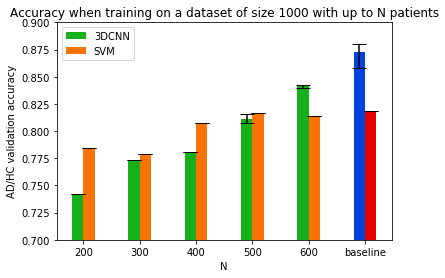

In [6]:
do_bars_comparison_plot({
    'baseline': (BASELINE_RUNS['cnn'], BASELINE_RUNS['svm']),
    '200': ('20180410-124714', '20180410-151305'),
    '300': ('20180410-124751', '20180410-151343'),
    '400': ('20180410-124805', '20180410-162844'),
    '500': (['20180410-144746', '20180410-124820'], '20180410-162921'),
    '600': (['20180410-124838', '20180410-141605', '20180410-141608'], '20180410-163325'),
}, ('3DCNN', 'SVM'), 'N', 'Accuracy when training on a dataset of size 1000 with up to N patients')

Run 20180408-194221 (ADNI: AD_HC with SVM [C=1])
  ## Per class accuracy 0.8423952 (std=0.027 on the last 7 steps)
Run 20180408-194545 (ADNI: AD_HC with SVM [C=1], batch_size=48)
  ## Per class accuracy 0.84016114 (std=0.023 on the last 7 steps)
Run 20180408-231353 (ADNI: AD_HC with SVM [C=1], batch_size=48 +bn)
  ## Per class accuracy 0.8261555 (std=0.043 on the last 7 steps)
Run 20180408-231638 (ADNI: AD_HC with SVM [C=1], batch_size=48 +bn [nocenter/scale])
  ## Per class accuracy 0.8333334 (std=0.036 on the last 7 steps)


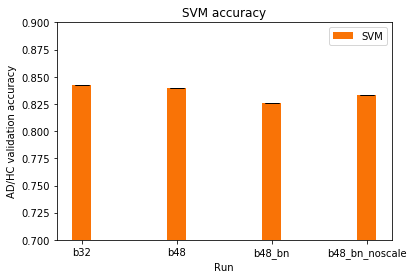

In [7]:
do_bars_comparison_plot({
    '01__b32': ('20180408-194221', ),
    '02__b48': ('20180408-194545', ),
    '03__b48_bn': ('20180408-231353', ),
    '04__b48_bn_noscale': ('20180408-231638', ),
}, ('SVM', ), 'Run', 'SVM accuracy')

Run 20180410-173322 (3DCNN: Normalization exp [nonorm_cnn])
  ## Per class accuracy 0.8275561 (std=0.030 on the last 7 steps)
Run 20180410-163340 (3DCNN: Normalization exp [nonorm_bn_cnn])
  ## Per class accuracy 0.84051126 (std=0.025 on the last 7 steps)
Run 20180410-151726 (3DCNN: Normalization exp [dn_cnn])
  ## Per class accuracy 0.8506654 (std=0.016 on the last 7 steps)
Run 20180409-195126 (CNN ADNI_AIBL_T1_normalized batch=48)
  ## Per class accuracy 0.8807773 (std=0.011 on the last 7 steps)
Run 20180411-005423 (3DCNN: batch_size=48 (py_streaming))
  ## Per class accuracy 0.872549 (std=0.012 on the last 7 steps)
Run 20180410-151641 (3DCNN: Normalization exp [dn_bn_cnn])
  ## Per class accuracy 0.86029404 (std=0.017 on the last 7 steps)
Run 20180407-101054 (AD_HC: Remove 512 fc [batch=48])
  ## Per class accuracy 0.8781513 (std=0.014 on the last 7 steps)
Run 20180407-101051 (AD_HC: Remove 512 fc [batch=48])
  ## Per class accuracy 0.8569678 (std=0.017 on the last 7 steps)


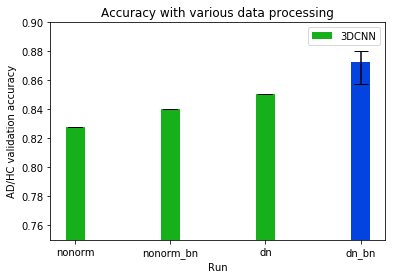

In [8]:
do_bars_comparison_plot({
    '01__nonorm': ('20180410-173322', ),
    '02__nonorm_bn': ('20180410-163340', ),
    '03__dn': ('20180410-151726', ),
    '04_baseline__dn_bn': (BASELINE_RUNS['cnn'], ),
}, ['3DCNN'], 'Run', 'Accuracy with various data processing', ylim=[0.75, 0.9])

Run 20180411-010527 (3DCNN: batch_size=4 (py_streaming))
  ## Per class accuracy 0.83351105 (std=0.016 on the last 7 steps)
Run 20180411-065451 (3DCNN: batch_size=4 (py_streaming, without BN))
  ## Per class accuracy 0.84896946 (std=0.021 on the last 7 steps)
Run 20180410-230522 (3DCNN: batch_size=8 (py_streaming))
  ## Per class accuracy 0.8456507 (std=0.013 on the last 7 steps)
Run 20180411-071435 (3DCNN: batch_size=8 (py_streaming, without BN))
  ## Per class accuracy 0.8493635 (std=0.018 on the last 7 steps)
Run 20180410-230647 (3DCNN: batch_size=16 (py_streaming))
  ## Per class accuracy 0.8594188 (std=0.014 on the last 7 steps)
Run 20180411-102359 (3DCNN: batch_size=16 (py_streaming))
  ## Per class accuracy 0.87097347 (std=0.017 on the last 7 steps)
Run 20180411-011551 (3DCNN: batch_size=16 (py_streaming, without BN))
  ## Per class accuracy 0.8646709 (std=0.008 on the last 7 steps)
Run 20180410-230608 (3DCNN: batch_size=32 (py_streaming))
  ## Per class accuracy 0.85731465 (std

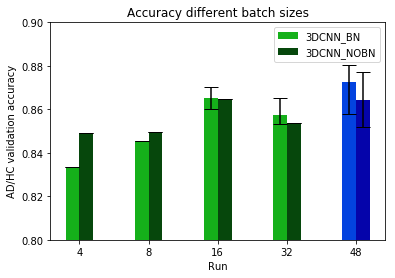

In [9]:
do_bars_comparison_plot({
    '01__4': ('20180411-010527', '20180411-065451', ),
    '02__8': ('20180410-230522', '20180411-071435', ),
    '03__16': (['20180410-230647', '20180411-102359'], '20180411-011551', ),
    '04__32': (['20180410-230608', '20180407-020135', '20180406-222733'], '20180411-014406', ),
    '05_baseline__48': (BASELINE_RUNS['cnn'], ['20180410-151726', '20180411-100354']),
}, ['3DCNN_BN', '3DCNN_NOBN'], 'Run', 'Accuracy different batch sizes', ylim=[0.80, 0.90])

Run 20180411-165025 (3DCNN: 10 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.7140931 (std=0.002 on the last 10 steps)
Run 20180411-145142 (3DCNN: Inceptionv3: 10 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.66193974 (std=0.007 on the last 7 steps)
Run 20180411-183437 (SVM: 10 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.69558823 (std=0.002 on the last 5 steps)
Run 20180411-130243 (3DCNN: 20 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.70772064 (std=0.003 on the last 10 steps)
Run 20180411-120122 (3DCNN: Inceptionv3: 20 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.7078082 (std=0.004 on the last 7 steps)
Run 20180411-183512 (SVM: 20 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.6230392 (std=0.142 on the last 5 steps)
Run 20180411-144539 (3DCNN: 40 patients / 2 img per patient [batch_size=16])
  ## Per class accuracy 0.72120106 (st

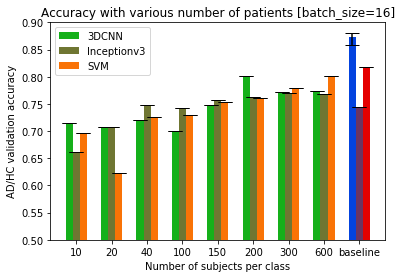

In [10]:
do_bars_comparison_plot({
    '999__baseline': (BASELINE_RUNS['cnn'], BASELINE_RUNS['inception'], BASELINE_RUNS['svm']),
    '010__10': ('20180411-165025', '20180411-145142', '20180411-183437', ),
    '020__20': ('20180411-130243', '20180411-120122', '20180411-183512', ),
    '040__40': ('20180411-144539', '20180411-130135', '20180411-190147', ),
    '100__100': ('20180411-135452', '20180411-152131', '20180411-183810', ),
    '150__150': ('20180411-172647', '20180411-195756', '20180411-192843'),
    '200__200': ('20180411-142421', '20180411-165904', '20180411-190023', ),
    '300__300': ('20180411-172727', '20180411-195802', ['20180411-192830', '20180411-201431']),
    '600__600': ('20180411-173518', '20180411-195730', '20180411-190904', ),
}, ['3DCNN', 'Inceptionv3', 'SVM'], 'Number of subjects per class', 'Accuracy with various number of patients [batch_size=16]', ylim=[0.50, 0.90])

Run 20180411-203444 (3DCNN: max_images_per_patient=1 [patients with 5 img only])
  ## Per class accuracy 0.8008579 (std=0.009 on the last 2 steps)
Run 20180411-222724 (3DCNN: max_images_per_patient=1 [patients with 5 img only])
  ## Per class accuracy 0.70465684 (std=0.105 on the last 3 steps)
Run 20180411-212836 (3DCNN: max_images_per_patient=1 [patients with 5 img only])
  ## Per class accuracy 0.6066176 (std=0.109 on the last 3 steps)
Run 20180411-205157 (3DCNN: max_images_per_patient=2 [patients with 5 img only])
  ## Per class accuracy 0.6164216 (std=0.049 on the last 2 steps)
Run 20180411-212840 (3DCNN: max_images_per_patient=2 [patients with 5 img only])
  ## Per class accuracy 0.8047385 (std=0.011 on the last 3 steps)
Run 20180411-203650 (3DCNN: max_images_per_patient=3 [patients with 5 img only])
  ## Per class accuracy 0.8106618 (std=0.001 on the last 2 steps)
Run 20180411-222726 (3DCNN: max_images_per_patient=3 [patients with 5 img only])
  ## Per class accuracy 0.8210785 (s

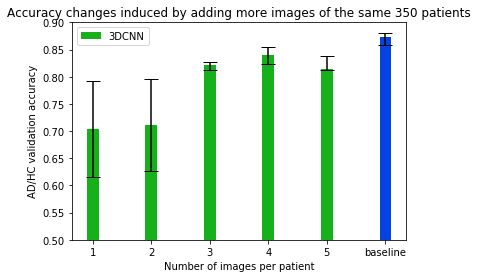

In [11]:
do_bars_comparison_plot({
    '01__1': (['20180411-203444', '20180411-222724', '20180411-212836'],),
    '02__2': (['20180411-205157', '20180411-212840'], ),
    '03__3': (['20180411-203650', '20180411-222726', '20180411-212847'], ),
    '04__4': (['20180411-204710', '20180411-212857'], ),
    '05__5': (['20180411-203615', '20180411-223602', '20180411-221621', '20180411-215725'], ),
    '999__baseline': (BASELINE_RUNS['cnn'], ),
}, ['3DCNN',], 'Number of images per patient', 'Accuracy changes induced by adding more images of the same 350 patients', ylim=[0.50, 0.90])

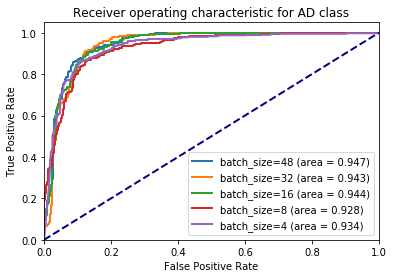

In [12]:
def roc_curves(runs, avg_scores):
    plt.figure()
    
    for run_label, run_reason in runs:
        y_scores = []
        dump_tensors = load_tensors_dump(run_label)
        image_data = {}
        for step in avg_scores:
            run_data = dump_tensors[dump_tensors.keys()[step]]
            for _run_data in run_data:
                for i, image_label in enumerate(_run_data['classifier/image_label']):
                    image_label = image_label[0]
                    if image_label not in image_data:
                        image_data[image_label] = {
                            'scores': [],
                            'label': np.argmax(_run_data['classifier/labels'][i]),
                        }
                    image_data[image_label]['scores'].append(_run_data['classifier/proba'][i][CLASS_AD])
        y_scores = [np.median(d['scores']) for d in image_data.values()]
        y_true = [d['label'] for d in image_data.values()]
        pos_label = CLASS_AD
        fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores, pos_label=pos_label)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr,
                 lw=2, label='%s (area = %0.3f)' % (run_reason, roc_auc))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for AD class')
    plt.legend(loc="lower right")
    plt.show()

roc_curves([
    ('20180411-005423', 'batch_size=48'),
    ('20180410-230608', 'batch_size=32'),
    ('20180410-230647', 'batch_size=16'),
    ('20180410-230522', 'batch_size=8'),
    ('20180411-010527', 'batch_size=4')
], avg_scores=range(-10, 0))